In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

In [3]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids

#------------------------------------------------------------------
# help function to parse the board name from the file

def get_board_label(filename):
    
    head, tail = os.path.split(filename)
    buf = tail.removesuffix(".fcl").removeprefix("icaruspmt")
    geo = buf[0:2]
    pos = buf[2:-2]
    slot = buf[-2:]
  
    if slot == "01":
        slot = "A"
    elif slot == "02":
        slot = "B"
    elif slot == "03":
        slot = "C"

    board_label = geo.upper() + "-" + pos.upper() + "-" + slot
    
    return board_label

#-------------------------------------------------------------------
# read baselines from config file

def readFile( filename, baselines ):
    
	readfile = open( filename, 'r' )
	board_label = get_board_label(filename)
	map = readSqlitedb()

	for line in readfile:

		line = line.strip()

		if "BaselineCh" in line:
        
			argline = line.split(".")[-1]
			buff = argline.split(":")		
			digitizer_channel = int(buff[0].split("Ch")[-1]) #these go from 1 to 16
			old_bl = int(buff[1])
            
			if (digitizer_channel != 16): #last digitizer channel has no pmt
                
				channel_id = get_channel_id(map, board_label, digitizer_channel-1) #in db, expected 0 to 15
				baselines[channel_id] = old_bl  
                                
	readfile.close()
	return baselines

### Baselines measured in Dec 2022 (run 9260)
These baselines were measured and placed in the configurations files. They were used to compute new thresholds... however the DC offset (channel pedestals) remained untouched at 6554

In [4]:
Dec2022_baselines = {}
foldername = "../pmt-thresholds-baselines/basedir/Physics_General_thr390_Majority_5_9_OverlappingWindow_wr_0_LockTemp_/"

pmt_components = [ filename for filename in os.listdir(foldername)  if "icaruspmt" in filename]

for pmt_component in pmt_components:
    readFile( foldername+pmt_component, Dec2022_baselines )

FileNotFoundError: [Errno 2] No such file or directory: '../pmt-thresholds-baselines/basedir/Physics_General_thr390_Majority_5_9_OverlappingWindow_wr_0_LockTemp_/'

### Baselines expected from channel-by-channel calibration
After the calibration, look at the baselines expected when setting 6554 for each channel

In [6]:
file = "calibrations/baselines_at_6554_2nd_23Feb2023.csv"
expected_baselines = pd.read_csv(file, sep=',')

Comparing channel-by-channel

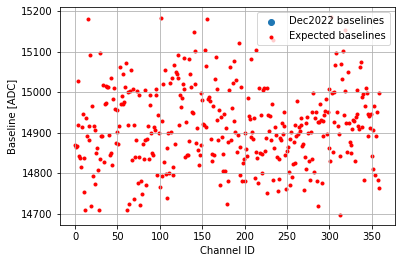

In [24]:
plt.scatter(Dec2022_baselines.keys(),Dec2022_baselines.values(), label="Dec2022 baselines")
plt.scatter(expected_baselines["channel_id"],expected_baselines["baseline"], marker=".", color="red", label="Expected baselines")
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.legend()
plt.show()

For channel, compute the difference and plot an histogram!

In [25]:
diff = []
for ch in range(0,360):
    
    dec2022 = Dec2022_baselines[ch]
    exp = expected_baselines[expected_baselines["channel_id"]==ch].baseline.values[0]
    diff.append(dec2022-exp)
    
plt.hist(diff, bins=150, range=(-300, 300), histtype='step', lw=2)
plt.grid()
plt.xlabel("Dec2022 - Expected baseline [ADC]")
plt.ylabel("# channels")
plt.show()

KeyError: 0

## Collecting each run for which pedestals were set to 6554
Starting from Dec2022, onwards, selecting runs in which pedestals were still 6554.
Looking channel by channel: what is the stability?
If there is no stability, calibrating is useless!

Goal is to see max 20 ADC counts of spread!

In [4]:
def get_channel_dict(data, n=20):
    
    bs = {}    
    for ch in range(0,360):
        col = "baseline_ch" + str(ch)
        baselines = data[col].head(n).to_numpy()
    
        bs[ch] = np.median(baselines)

    return bs

In [12]:
file = "../runs/9582/measChannelBaselines_run9582.csv"
bs9499 = pd.read_csv(file,sep=",")
bs9499 = get_channel_dict(bs9499)

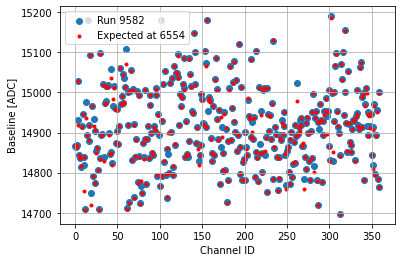

In [13]:
plt.scatter(bs9499.keys(),bs9499.values(), label="Run 9582")
plt.scatter(expected_baselines["channel_id"],expected_baselines["baseline"], marker=".", color="red", label="Expected at 6554")
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.legend()
plt.show()

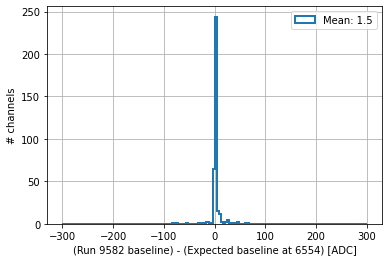

In [14]:
diff = []
for ch in range(0,360):
    
    bs = bs9499[ch]
    exp = expected_baselines[expected_baselines["channel_id"]==ch].baseline.values[0]
    diff.append(bs-exp)
    
plt.hist(diff, bins=150, range=(-300, 300), histtype='step', lw=2, label="Mean: {:.1f}".format(np.mean(diff)))
plt.grid()
plt.xlabel("(Run 9582 baseline) - (Expected baseline at 6554) [ADC]")
plt.ylabel("# channels")
plt.legend()
plt.show()

## Looking at runs in the same exact conditions!

Physics runs for which the configuration was EXACTLY the same: same pedestal (6554), same DAQ code, same parameters in the configuration: ```Physics_General_thr390_Majority_5_9_OverlappingWindow_wr_0_LockTemp_00002```

In [7]:
runs = [9513, 9531, 9533, 9534, 9558, 9560, 9562]
map = readSqlitedb()
boards = map["digitizer_label"].to_numpy()
boards = np.unique(boards)
bs = {}
for run in runs:
    file = "../runs/"+str(run)+"/measChannelBaselines_run"+str(run)+".csv"
    df = pd.read_csv(file,sep=",")
    bs[run] = get_channel_dict(df)

In [5]:
### PLOT BASELINE FOR EACH EVENT: shows how much spread during time evolution as a histogram
### plots all channels in the same board
def plot_single_channel_baselines(bs, runs, ch, ranges):
    
    print("Channel: " + str(ch))
    fig = plt.figure()
        
    for run in runs:
        plt.hist( bs[run][ch], bins=200, range=ranges, label="Run {:d}".format(run) , histtype='step', lw=2)
        
    plt.xlabel("Baseline [ADC]",fontsize=16)
    plt.title("Channel: " + str(ch))
    plt.legend()
   

In [6]:
### PLOT BASELINE FOR EACH EVENT: shows how much spread during time evolution as a histogram
### plots all channels in the same board
def plot_channel_baselines(bs, geo, runs, board, ranges):
    
    print("Board: " + board)
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for digch in range(15):
        
        ch = get_channel_id(geo,board,digch)
        ax = fig.add_subplot(4,4,digch+1)
    
        for run in runs:
            ax.hist( bs[run][ch], bins=500, range=ranges, label="Run {:d}".format(run) , histtype='step', lw=2)
            
        ax.legend()
        ax.set_title("Channel "+str(ch))
        
    fig.supxlabel("Baseline [ADC]",fontsize=16)
    plt.tight_layout()

Board: WW-TOP-A
Board: EE-TOP-A


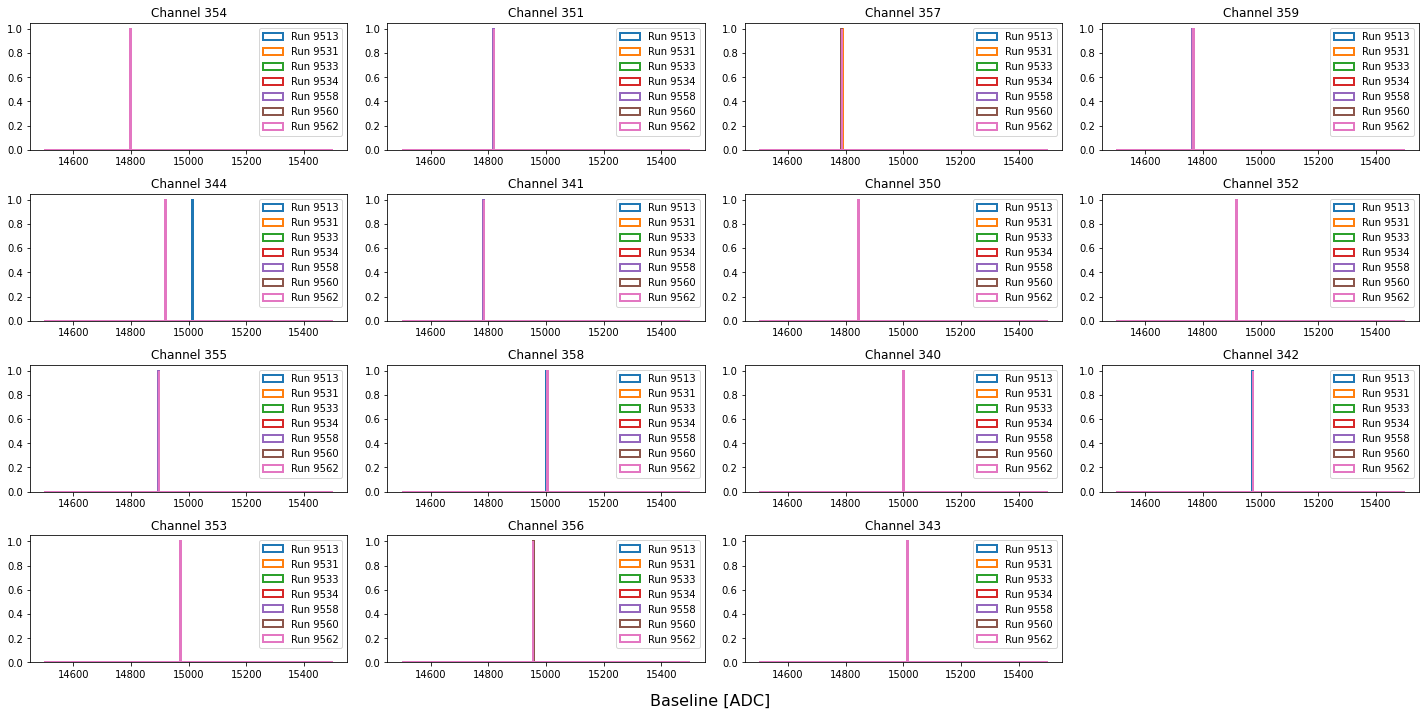

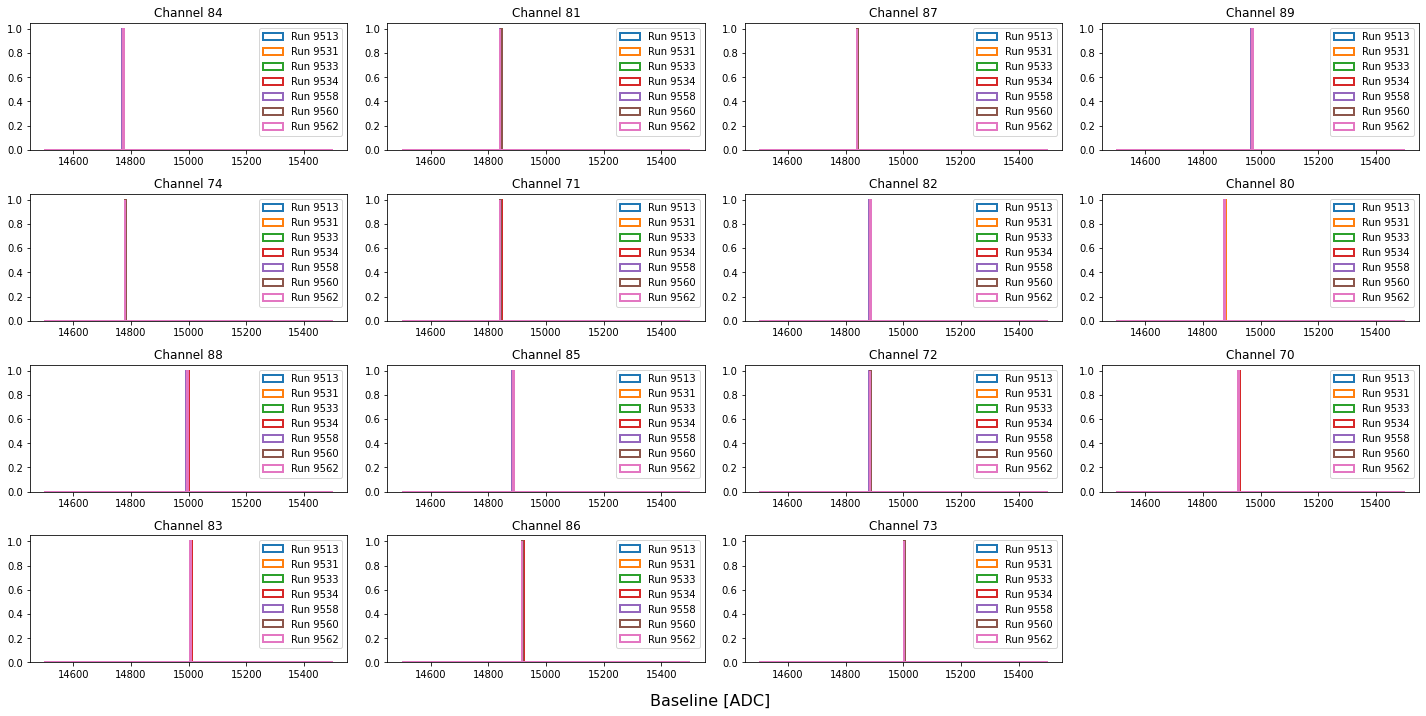

In [10]:
#for board in boards:
plot_channel_baselines(bs,map,runs,"WW-TOP-A",ranges=(14500,15500))
plot_channel_baselines(bs,map,runs,"EE-TOP-A",ranges=(14500,15500))

Board: WW-TOP-B
Board: EE-TOP-B


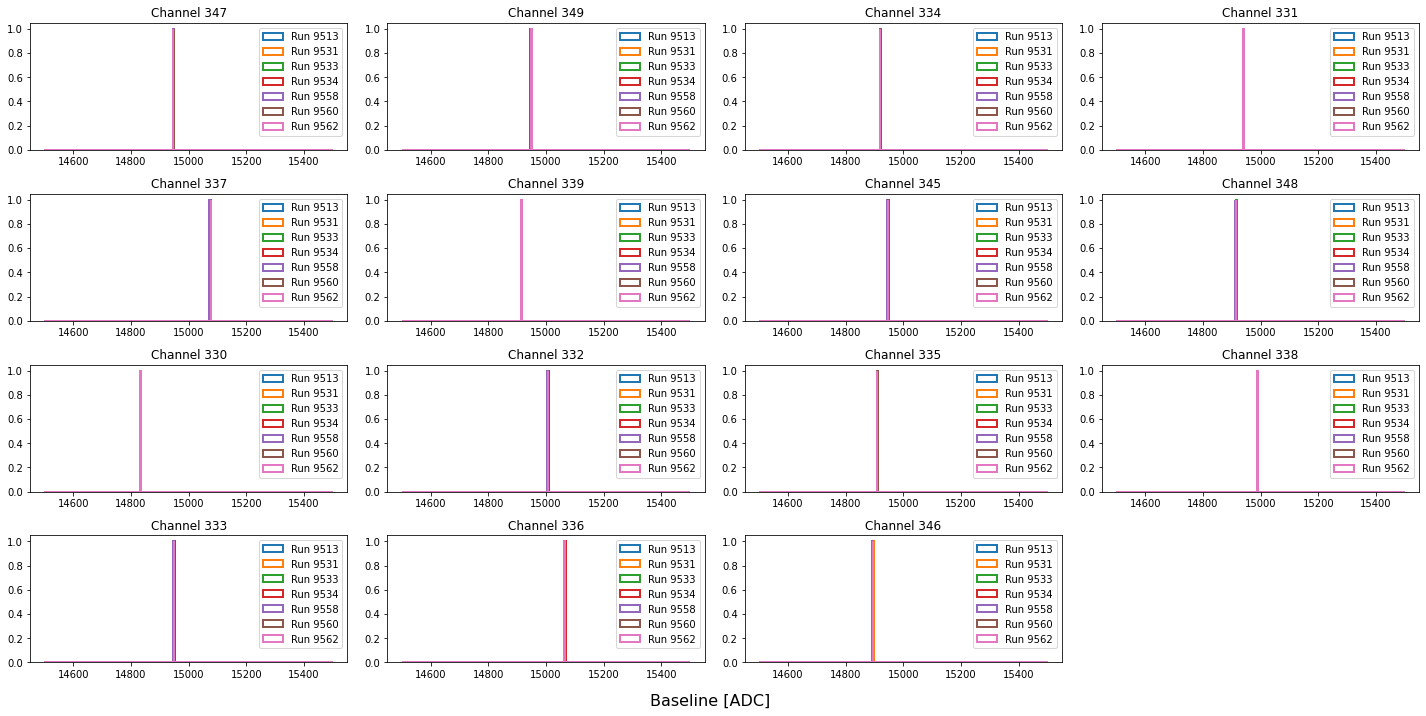

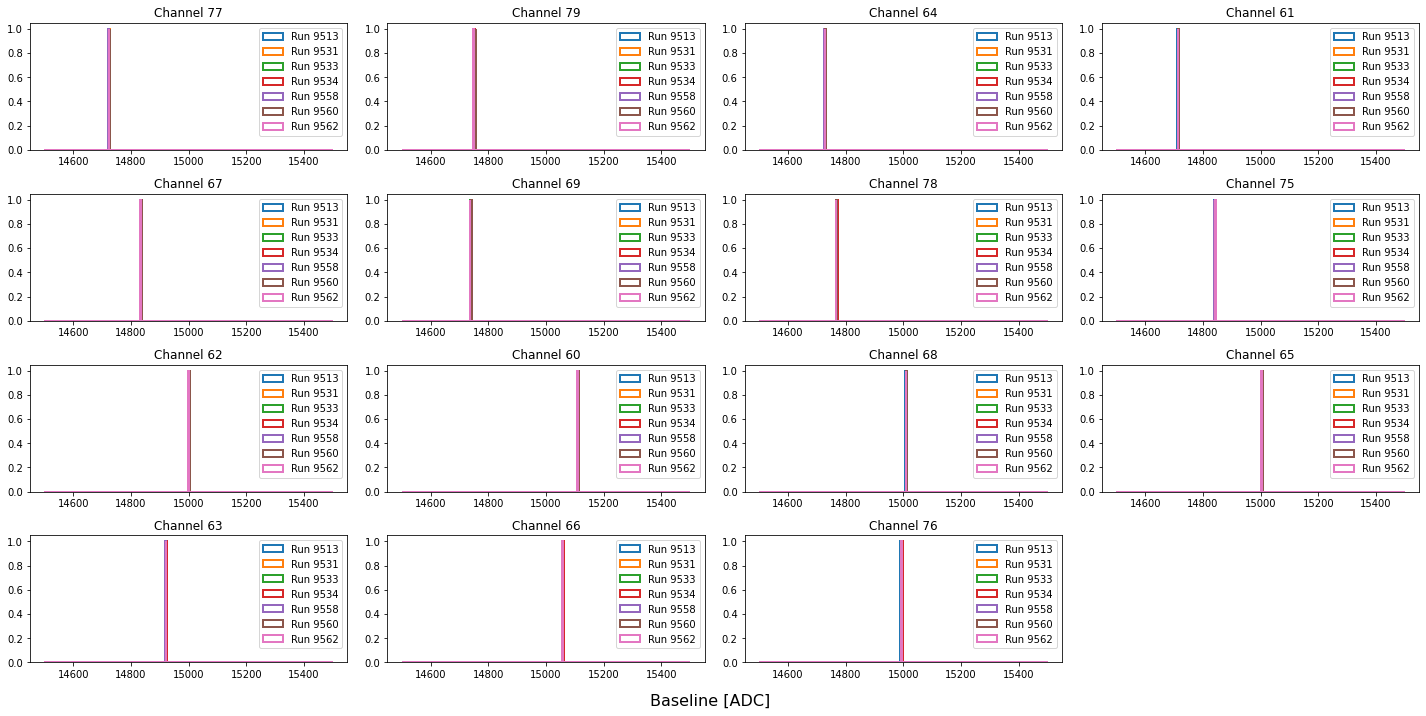

In [11]:
plot_channel_baselines(bs,map,runs,"WW-TOP-B",ranges=(14500,15500))
plot_channel_baselines(bs,map,runs,"EE-TOP-B",ranges=(14500,15500))

Board: WW-TOP-C
Board: EE-TOP-C


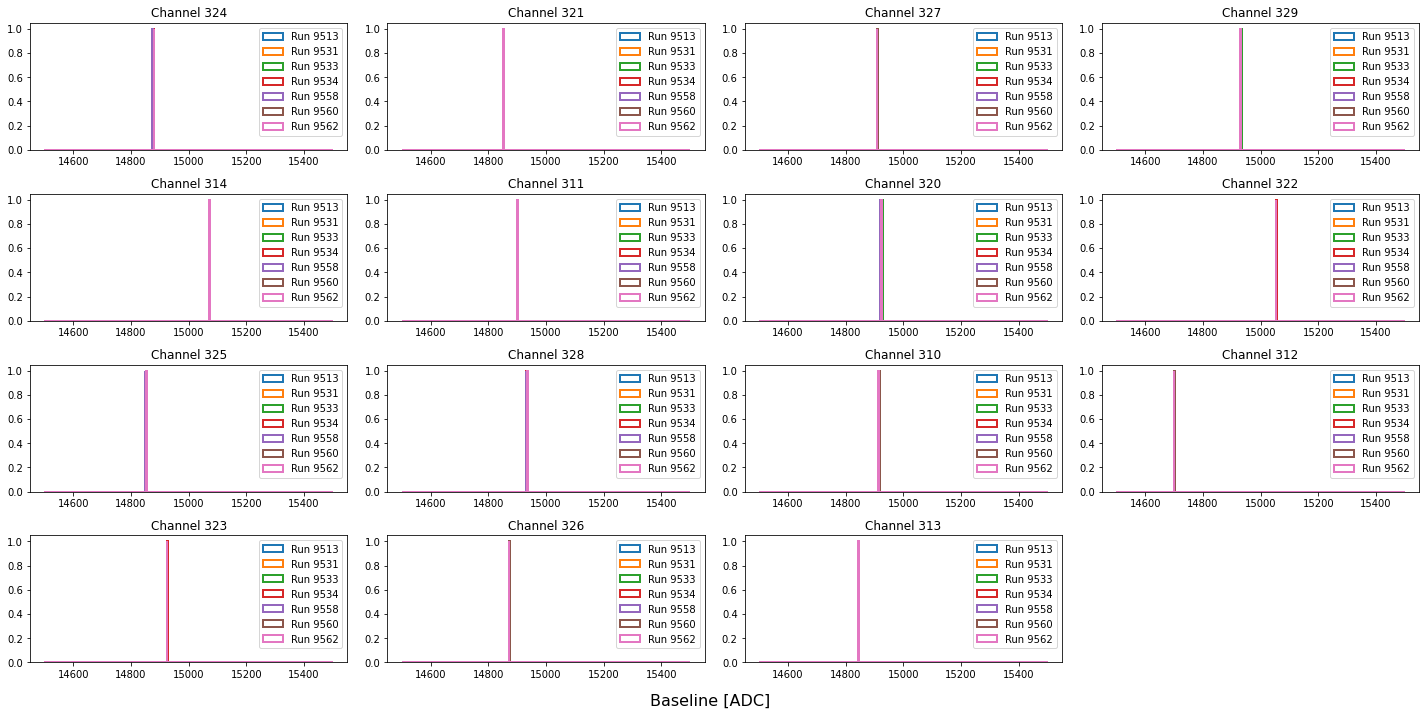

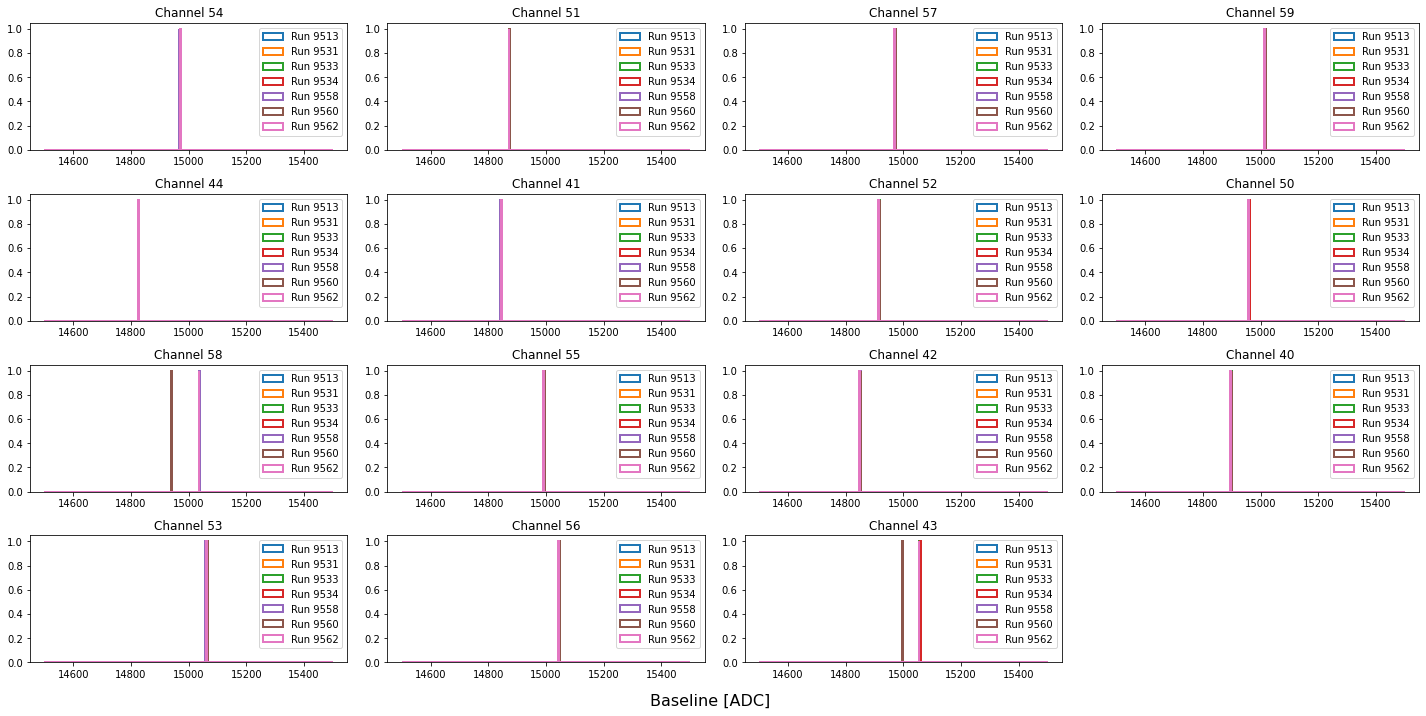

In [8]:
plot_channel_baselines(bs,map,runs,"WW-TOP-C",ranges=(14500,15500))
plot_channel_baselines(bs,map,runs,"EE-TOP-C",ranges=(14500,15500))

Board: EW-TOP-A
Board: WE-TOP-A


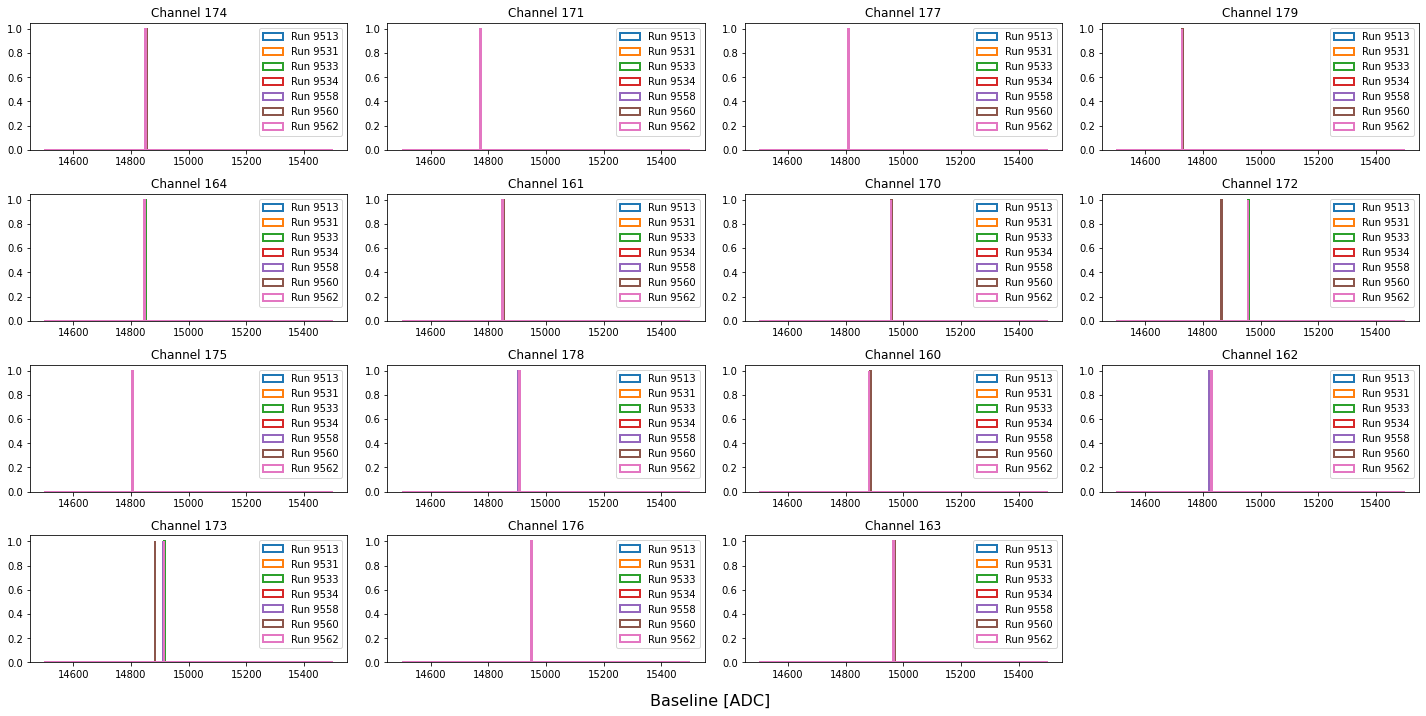

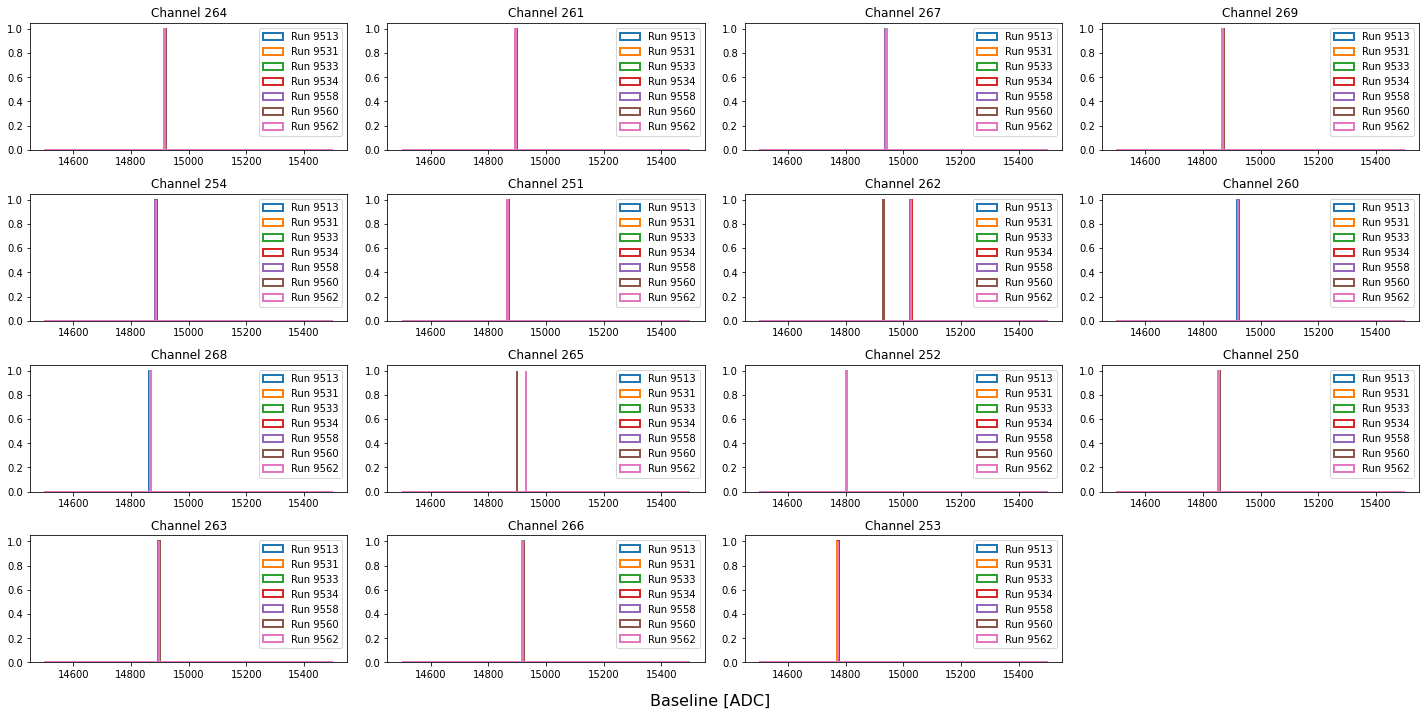

In [9]:
plot_channel_baselines(bs,map,runs,"EW-TOP-A",ranges=(14500,15500))
plot_channel_baselines(bs,map,runs,"WE-TOP-A",ranges=(14500,15500))

Channel: 344


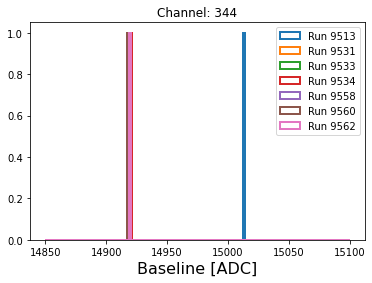

In [12]:
plot_single_channel_baselines(bs, runs, 344,ranges=(14850,15100))